In [2]:
# NOTE: Run this in Python 2.7
import requests
import urllib
import imdb
import lxml.html
import numpy as np
import pandas as pd
import itertools
%matplotlib inline
import seaborn as sns
import math
import matplotlib.pyplot as plt

# Load all movies and combine 

In [5]:
movies_1 = pd.read_csv('../milestone1/tmdb-movies-1-to-400.csv')
movies_2 = pd.read_csv('../milestone1/tmdb-movies_start_601_end_801.csv')
movies_combined = pd.concat([movies_1, movies_2])

In [8]:
# helper functions to format genre ids from arrays to strings and from ids to genre names
def requestResults(url):
    r = requests.get(BASE_URL + url + "&api_key=" + API_KEY)
    return r.json()

# Constants
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "9767d17413ec9d9729c2cca238df02da"
GENRE_MAP = {}
for g in requestResults("genre/movie/list?x=1")[u'genres']:
    GENRE_MAP[g['id']] = g['name']

def idToName(idArrayStr):
    if idArrayStr == '[]':
        return ''
    idArray = np.array(np.matrix(idArrayStr))[0]
    genres = []
    for gid in idArray:
        if gid != 10769:
            genres.append(GENRE_MAP[gid])
    return ','.join(genres)

def idStrToArray(idArrayStr):
    if idArrayStr == '[]':
        return ''
    idArray = np.array(np.matrix(idArrayStr))[0]
    genres = []
    for gid in idArray:
        # unknown id 10769
        if gid != 10769:
            genres.append(str(gid))
    return ','.join(genres)

### Turn genre ids to genre names and remove genre with unknown id

In [9]:
movies_combined['genres'] = movies_combined['genre_ids'].apply(idToName)
movies_combined['genre_ids_cleaned'] = movies_combined['genre_ids'].apply(idStrToArray)

In [10]:
# remove unecessary columns 
movies_combined_cleaned = movies_combined.drop(labels=['adult', 'video', 'genre_ids'], axis=1)

In [11]:
# check unknown id has been removed
for i in range(movies_combined.shape[0]):
    row = movies_combined.iloc[i]
    if 'other' in row['genres']:
        print row['title'], ' num genres:', len(row['genres'].split(','))

### Count occurence of each genre in dataset 

In [19]:
genre_counts = {}
for i in range(movies_combined.shape[0]):
    row = movies_combined.iloc[i]
    genre_id_str = row['genre_ids_cleaned']
    genre_ids = []
    if genre_id_str != '[]':
        genre_ids = np.array(np.matrix(genre_id_str))[0]
    for gid in genre_ids:
        if gid not in genre_counts:
            genre_counts[gid] = 1
        else:
            genre_counts[gid] +=1

In [20]:
# turn genre id to genre name 
genre_count_names = {}
for name in genre_counts:
    if (name in GENRE_MAP):
        genre = GENRE_MAP[name]
    else:
        genre = name
    genre_count_names[str(genre)] = genre_counts[name]

In [22]:
genre_count_names

{'Action': 2648,
 'Adventure': 1667,
 'Animation': 865,
 'Comedy': 3675,
 'Crime': 1501,
 'Documentary': 306,
 'Drama': 5505,
 'Family': 1102,
 'Fantasy': 995,
 'History': 453,
 'Horror': 1456,
 'Music': 337,
 'Mystery': 845,
 'Romance': 1991,
 'Science Fiction': 1220,
 'TV Movie': 183,
 'Thriller': 2977,
 'War': 376,
 'Western': 214}

## Exploring keywords

In [23]:
movies = pd.read_csv('./all_movies_clean.csv').drop(labels=['Unnamed: 0'], axis=1)

In [26]:
# count keywords in data set
keyword_counts = []
for i in range(movies.shape[0]):
    if 'nan' not in str(movies['keywords'][i]):
        count = len(movies['keywords'][i].split(','))
    keyword_counts.append(count)
    
# find all unique keywords 
keywords = []
for i in range(movies.shape[0]):
    if 'nan' not in str(movies['keywords'][i]):
        keywords = keywords + movies['keywords'][i].split(',')
words, counts = np.unique(keywords, return_counts=True)

# sort by count of keywords in data set 
vals = zip(words, counts)
sorted_vals = sorted(vals, key = lambda t: t[1], reverse=True)

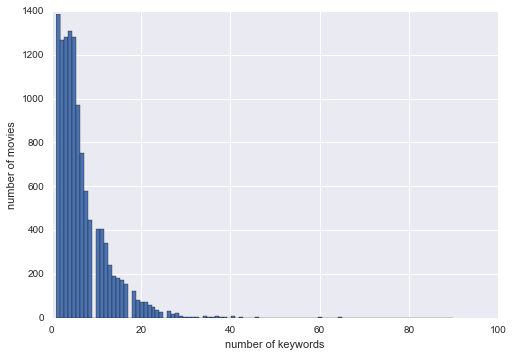

In [30]:
# histogram of number of keywords per movie
plt.hist(keyword_counts, bins=100)
plt.xlabel('number of keywords')
plt.ylabel('number of movies')
plt.show()

## One hot encoding of keywords as features

In [ ]:
movies_keywords_df = pd.DataFrame({'keywords': movies['keywords'].values, 'ids': movies['id'].values})
n = movies.shape[0]
for j, w in enumerate(words):
    if (j%100 == 0):
        print(j)
    one_hot_vector = np.zeros((n,1))
    for i in range(movies.shape[0]):
        if 'nan' not in str(movies['keywords'][i]):
            keywords = movies['keywords'][i].split(',')
            if w in keywords:
                one_hot_vector[j] = 1
    movies_keywords_df[w] = one_hot_vector